# Wine Quality Predictions

## Problem Definition

Is it possible to predict human wine taste preference based on physicochemical properties of the wine (such as pH, amount of sulfates and alcohol)? The purpose of this project is to answer this question with different machine learning methods.

## Retrieve the Dataset

The two datasets correspond to the red and white "Vinho Verde" wine (from Northern Portugal). For more detail please consult the original journal article. [[Cortez et al., 2009]](https://doi.org/10.1016/j.dss.2009.05.016)
This dataset is available from the UCI machine learning repository: https://archive.ics.uci.edu/ml/datasets/wine+quality

## Attribute Information

Predictor variables (all numerical):

1. fixed acidity           
2. volatile acidity        
3. citric acid             
4. residual sugar          
5. chlorides               
6. free sulfur dioxide     
7. total sulfur dioxide    
8. density                 
9. pH                      
10. sulphates               
11. alcohol                 

Target variable (categorical):

12. quality (0-10 scale)       

## Binary Classification

To simply the problem, we will only consider the red wines and classify these wines as "GOOD" and "BAD" ones by setting the bar at quality 6.5.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_red = pd.read_csv('./input/winequality-red.csv',sep=';')

Check whether there are missing values in the dataset.

In [3]:
df_red.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

## Correlation Matrix

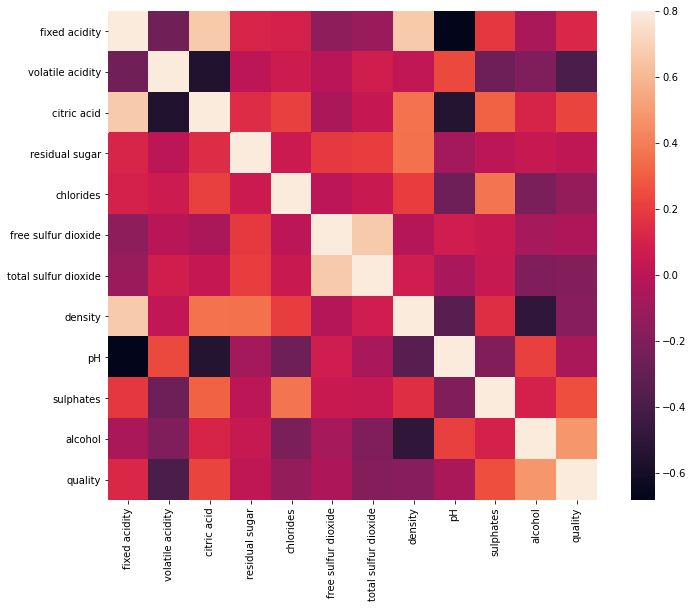

In [4]:
# correlation matrix
corrmat = df_red.corr() # correlation matrix calculated from pandas
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=.8, square=True)

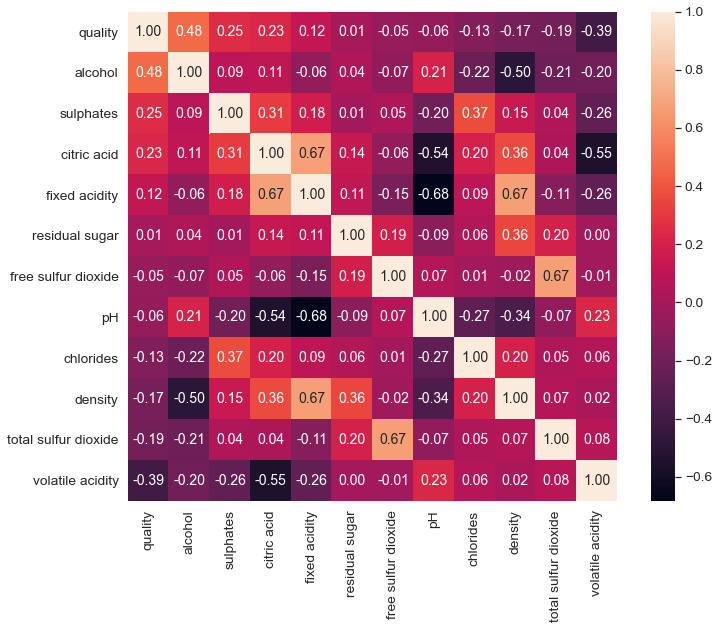

In [5]:
# quality correlation matrix
k = 12 # number of variables for heatmap
cols = corrmat.nlargest(k, 'quality')['quality'].index # select the column names that highly correlates with 'quality'
cm = np.corrcoef(df_red[cols].values.T) # calculate the Pearson product-moment correlation coefficients using numpy
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(12,9))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 14}, yticklabels=cols.values, xticklabels=cols.values)

C:\Users\Shuhao\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


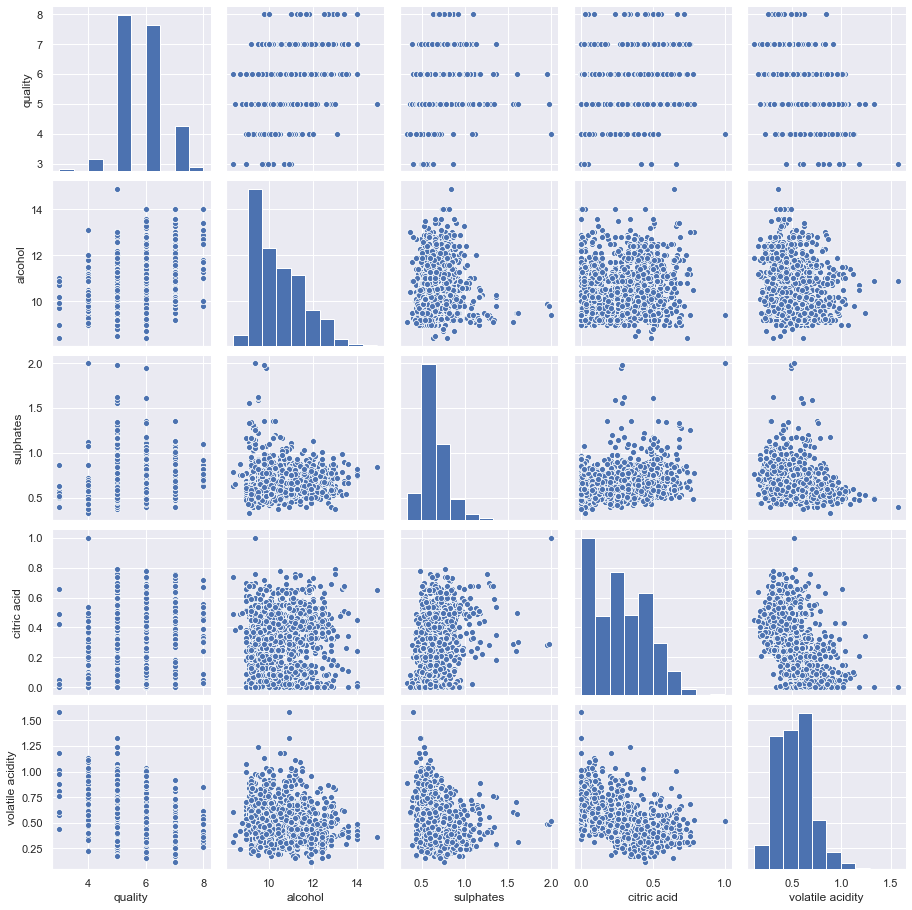

In [6]:
# scatterplot
sns.set()
cols = ['quality', 'alcohol', 'sulphates', 'citric acid', 'volatile acidity']
sns.pairplot(df_red[cols], size=2.5)
plt.show()

Add a columm 'binary quality' with values 0 and 1 that corresponds to 'quality' values lower or higher than 6.5.

In [7]:
df_red['binary quality'] = np.where(df_red.quality < 6.5, 0, 1)

In [8]:
# count the number of GOOD/BAD wine
df_red['binary quality'].value_counts()

0    1382
1     217
Name: binary quality, dtype: int64

In [9]:
X = df_red.loc[:, ~df_red.columns.isin(['quality','binary quality'])]
y = df_red['binary quality']

## Stratified sampling

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

In [11]:
y_train.value_counts()

0    1105
1     174
Name: binary quality, dtype: int64

In [12]:
y_test.value_counts()

0    277
1     43
Name: binary quality, dtype: int64

## Machine Learning Models

In [13]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss, accuracy_score, roc_curve, roc_auc_score, plot_roc_curve
from sklearn.model_selection import cross_val_score, cross_val_predict

### Logistic Regression

In [14]:
my_pipeline_logreg = Pipeline(steps=[('model',LogisticRegression(random_state=42, max_iter=1000))])
y_probas_logreg = cross_val_predict(my_pipeline_logreg, X_train, y_train, cv=5, method="predict_proba")

In [15]:
y_scores_logreg = y_probas_logreg[:, 1] # score = proba of positive class
fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(y_train, y_scores_logreg)

In [16]:
auc_score_logreg = roc_auc_score(y_train,y_scores_logreg)
print("Logistic ROC score:",auc_score_logreg)

Logistic ROC score: 0.8617673063920529


### Stochastic Gradient Descent Classifier

In [17]:
# my_model_sgd = SGDClassifier(random_state=42)
my_pipeline_sgd = Pipeline(steps=[('model', SGDClassifier(random_state=42))])
# my_model_sgd.fit(X_train,y_train)
y_scores_sgd = cross_val_predict(my_pipeline_sgd, X_train, y_train, cv=5, method="decision_function")

In [18]:
fpr_sgd, tpr_sgd, thresholds_sgd = roc_curve(y_train, y_scores_sgd)

In [19]:
auc_score_sgd = roc_auc_score(y_train,y_scores_sgd)
print("Logistic ROC score:",auc_score_sgd)

Logistic ROC score: 0.6872054922764862


### Support Vector Machines (SVM)

In [20]:
my_pipeline_svc = Pipeline(steps=[('model', SVC(random_state=42))])
y_scores_svc = cross_val_predict(my_pipeline_svc, X_train, y_train, cv=5, method="decision_function")

In [21]:
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_train, y_scores_svc)

In [22]:
auc_score_svc = roc_auc_score(y_train,y_scores_svc)
print("Logistic ROC score:",auc_score_svc)

Logistic ROC score: 0.8110833723409788


### Random Forest Classifier

In [23]:
def get_score(n_estimators):
    """Return the average MAE over 5 CV folds of random forest model.
    
    Keyword argument:
    n_estimators -- the number of trees in the forest
    """
    # Replace this body with your own code
    my_pipeline = Pipeline(steps=[('model', RandomForestClassifier(n_estimators=n_estimators, random_state=42))])
    scores = -1 * cross_val_score(my_pipeline, X_train, y_train,
                              cv=5,
                              scoring='neg_log_loss')
    return scores.mean()

In [24]:
results = {i:get_score(i) for i in range(50,450,50)} # Your code here

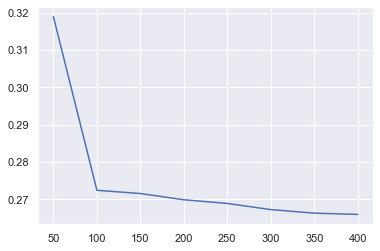

In [25]:
plt.plot(list(results.keys()), list(results.values()))
plt.show()

In [26]:
# n_estimators = 100 has the best result
my_pipeline_rfst = Pipeline(steps=[('model', RandomForestClassifier(n_estimators=100, random_state=42))])
y_probas_rfst = cross_val_predict(my_pipeline_rfst, X_train, y_train, cv=5, method="predict_proba")

In [27]:
y_scores_rfst = y_probas_rfst[:, 1] # score = proba of positive class
fpr_rfst, tpr_rfst, thresholds_rfst = roc_curve(y_train, y_scores_rfst)

In [28]:
auc_score_rfst = roc_auc_score(y_train,y_scores_rfst)
print("Logistic ROC score:",auc_score_rfst)

Logistic ROC score: 0.8983486763405627


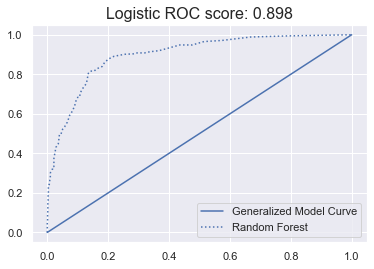

In [29]:
plt.plot([0,1],[0,1],linestyle="-",label="Generalized Model Curve")
plt.plot(fpr_rfst, tpr_rfst,"b:", label='Random Forest')
plt.legend()
plt.title(f'Logistic ROC score: {auc_score_rfst:.3f}', fontsize=16)
plt.show()

## Comparing ROC Curves across different models

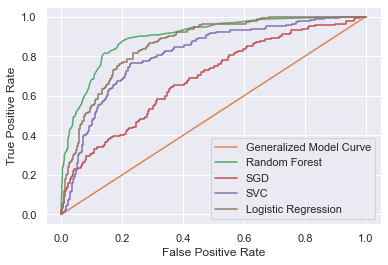

In [30]:
plt.plot([0,1],[0,1],"C1-",label="Generalized Model Curve")
plt.plot(fpr_rfst, tpr_rfst,"C2-", label='Random Forest')
plt.plot(fpr_sgd, tpr_sgd,"C3-", label='SGD')
plt.plot(fpr_svc, tpr_svc,"C4-", label='SVC')
plt.plot(fpr_logreg, tpr_logreg,"C5-", label='Logistic Regression')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title(f'(RF, SGD) ROC score: ({auc_score_rfst:.3f}, {auc_score_sgd:.3f})', fontsize=16)
plt.show()

In [31]:
df_red.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
binary quality            int32
dtype: object